In [2]:
import os
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [1]:
# Implement ConvPool-CNN-C architecture for calculating deep learning features, similar to Wang et al.

class ConvPoolCNN(nn.Module):
    """
    Implementation of the ConvPool-CNN-C architecture.
    Ref.: Springenberg et al. (2015), 'Striving for Simplicity: The All Convolutional Net'.
    Choice of network parameters (filters number, kernel size) for each of the Conv1D layers: (32, 60), (32, 60), (32, 30), (32, 30).
    """

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=60, padding="same")
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=60, padding="same")

        # MaxPooling1D
        self.pool = nn.MaxPool1d(kernel_size=2) # stride = same as kernel size by default

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=30, padding="same")
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=30, padding="same")

        # GlobalAveragePooling1D (Deep learning features extractor?)
        # Output layer. Deep learning features (32 dim).
        self.global_avg_pool = nn.AdaptiveAvgPool1d(output_size=1)

        self.fc = nn.Linear(32, 1) # Raw logits. For prediction/inference.

    def forward_features(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.global_avg_pool(x)
        # Output layer. Deep-learning features (32 of them)
        x = x.view(-1, 32)  # shape: [batch_size, 32]
        return x

    def forward(self, x):
        # If wanting to get a final output (e.g. regression or classification)
        x = self.forward_features(x)
        x = self.fc(x)
        return x

# Simple feed forward neural network (FFN), for testing purposes
class SimpleFFN(nn.Module):
    def __init__(self, input_dim=500):
        super().__init__()
        # Flatten the 1D input
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # x shape: [batch_size, 1, seq_len]
        # Flatten out the sequence dimension
        x = x.squeeze(1)             # [batch_size, seq_len]
        x = x.view(x.size(0), -1)    # [batch_size, seq_len]
        x = F.relu(self.fc1(x))      # [batch_size, 32]
        x = self.fc2(x)              # [batch_size, 1] (logits)
        return x

class CNN_more_simple(nn.Module):
    """
    Based on the ConvPool-CNN-C architecture, but with some layers removed.
    Ref.: Springenberg et al. (2015), 'Striving for Simplicity: The All Convolutional Net'.
    Choice of network parameters (filters number, kernel size) for each of the Conv1D layers: (32, 60), (32, 60), (32, 30), (32, 30).
    """

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=60, padding="same")

        # MaxPooling1D
        self.pool = nn.MaxPool1d(kernel_size=2) # stride = same as kernel size by default

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=30, padding="same")

        # GlobalAveragePooling1D
        # Output layer. Deep learning features (32 dim)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(output_size=1)

        self.fc = nn.Linear(32, 1) # Raw logits. For prediction/inference

    def forward_features(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.global_avg_pool(x)

        # Output layer. Deep-learning features (32 of them)
        x = x.view(-1, 32)  # shape: [batch_size, 32]
        return x

    def forward(self, x):
        # If wanting to get a final output (e.g. regression or classification)
        x = self.forward_features(x)
        x = self.fc(x)
        return x

class CNN_even_more_simple(nn.Module):
    """
    Based on the ConvPool-CNN-C architecture, but with some layers removed.
    Ref.: Springenberg et al. (2015), 'Striving for Simplicity: The All Convolutional Net'.
    Choice of network parameters (filters number, kernel size) for each of the Conv1D layers: (32, 60), (32, 60), (32, 30), (32, 30).
    """

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=60, padding="same")

        # MaxPooling1D
        self.pool = nn.MaxPool1d(kernel_size=2) # stride = same as kernel size by default

        # GlobalAveragePooling1D (Deep learning features extractor?)
        # Output layer. Deep learning features (32 dim).
        self.global_avg_pool = nn.AdaptiveAvgPool1d(output_size=1)

        self.fc = nn.Linear(32, 1) # Raw logits. For prediction/inference.

    def forward_features(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.global_avg_pool(x)

        # Output layer. Deep-learning features (32 of them)
        x = x.view(-1, 32)  # shape: [batch_size, 32]
        return x

    def forward(self, x):
        # If wanting to get a final output (e.g. regression or classification)
        x = self.forward_features(x)
        x = self.fc(x)
        return x

In [2]:
# Create a Pytorch Dataset.

class RRIDataset(Dataset):
    """
    Expects a DataFrame where each row is one RRI segment with columns:
        segment_id (str)
        RR_interval_sec (list of floats)
        label (0 or 1)
        [optionally database or other info about the segment, which we can ignore here]
    """
    def __init__(self, df_segments):
        self.df = df_segments.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # The time-series of RR intervals
        rri_list = row["RR_interval_sec"]

        # Convert to torch.FloatTensor.
        # Shape will be [sequence_length]. We unsqueeze(0) so that
        # final shape is [1, sequence_length] (i.e. one channel)
        rri_tensor = torch.tensor(rri_list, dtype=torch.float).unsqueeze(0)

        # Convert label to float. For BCEWithLogitsLoss, label should be float 0.0 or 1.0
        label = torch.tensor(row["label"], dtype=torch.float)

        return rri_tensor, label


In [25]:
# Train model (test script, using only a small subset of the training set)

def group_subject_RRI_data_by_segment_id(df_subject):
    # df_subject: DataFrame with the following columns: , RR_interval_sec, sample_start, sampling_frequency, record, segment_id, label
    # Returns a new DataFrame with columns: segment_id, RR_interval_sec (as a list), label.

    # Group by segment_id, gather the RRI arrays
    df_segmented = (
        df_subject
        .groupby("segment_id")
        .agg({"RR_interval_sec": list,
              "label": "first"})
        .reset_index()
    )
    return df_segmented


def create_segmented_subset_of_data(dataset_split_info_file_path, rri_dir, n_subjects='all', n_segments='all'):
    """
    1) Reads the partition CSV (e.g. db1_training_set_1.csv) which has columns
       ['subject_id', 'database', 'CHF'].
    2) Randomly selects n_subjects from that partition.
    3) For each selected subject, reads the corresponding CSV from
       `rri_dir/<database>/<database>_<subject_id>_RRI.csv`, groups by segment_id, and
       randomly chooses n_segments.
    4) Concatenates the results into a single DataFrame and returns it.

    Parameters
    ----------
    dataset_split_info_file : str
        Path to the partition file, e.g. "../data/dataset_splits/db1_training_set_1.csv"
    rri_dir : str
        Path to the root folder that contains subfolders like "BIDMC-CHF", "NSR", "FD", etc.
    n_subjects : int
        Number of subjects to randomly sample from the partition file.
    n_segments : int
        Number of segments to randomly sample from each subject.

    Returns
    -------
    subset_df : pd.DataFrame
        A segment-level DataFrame with columns: ['segment_id', 'RR_interval_sec', 'label']
    """
    # Load the partition info
    df_partition = pd.read_csv(dataset_split_info_file_path)

    # Select subjects from the partition
    if isinstance(n_subjects, str) and n_subjects.lower() == 'all':
        df_chosen = df_partition
    else:
        # Split the partition by CHF status
        df_chf_1 = df_partition[df_partition['CHF'] == 1]
        df_chf_0 = df_partition[df_partition['CHF'] == 0]

        # Ensure n_subjects is at least 2 to accommodate both classes
        n_subj = max(2, min(len(df_partition), n_subjects))

        # Sample approximately the same number of CHF=1 and CHF=0
        n_chf_1 = n_subj // 2
        n_chf_0 = n_subj - n_chf_1

        # Sample from each class
        df_chosen_chf_1 = df_chf_1.sample(n=min(len(df_chf_1), n_chf_1))
        df_chosen_chf_0 = df_chf_0.sample(n=min(len(df_chf_0), n_chf_0))

        # Combine the samples
        df_chosen = pd.concat([df_chosen_chf_1, df_chosen_chf_0])

    # For each chosen subject, read the RRI CSV, group by segment_id, then optionally sample segments
    subset_dfs = []
    for _, row in df_chosen.iterrows():
        subject_id = row['subject_id']
        db_name = row['database']  # e.g. "BIDMC-CHF", "NSR", "FD", etc.
        db_name = 'FD' if db_name == 'Fantasia' else db_name # Special case fix
        subject_label = row['CHF']  # e.g. 0 or 1

        # Construct the path to the subject's CSV
        # e.g.: "../data/cleaned_RRIs/with_segment_ids_N500/BIDMC-CHF/chf02_RRI.csv"
        csv_filename = f"{db_name}_{subject_id}_RRI.csv"
        csv_path = os.path.join(rri_dir, db_name, csv_filename)

        # Read the subject's data
        df_subject = pd.read_csv(csv_path)

        # Group by segment_id
        df_segmented = group_subject_RRI_data_by_segment_id(df_subject)

        df_segmented['database'] = db_name
        df_segmented['subject_id'] = subject_id
        # Optionally override the label (to ensure subject-level label is consistent)
        df_segmented['label'] = subject_label

        # Select segments from this subject
        if isinstance(n_segments, str) and n_segments.lower() == 'all':
            # Take all segments from this subject
            df_sampled = df_segmented
        else:
            # Randomly sample n_segments
            n_segs = min(len(df_segmented), n_segments)
            df_sampled = df_segmented.sample(n=n_segs)

        subset_dfs.append(df_sampled)

    # Concatenate all chosen subjects into one DataFrame
    subset_segmented_df = pd.concat(subset_dfs, ignore_index=True)
    return subset_segmented_df


# Train/val/test sets subjects, overview

# Load segmented RRI data into Dataframes
on_colab = True # Set to True if currently using google Colab for using files on Google Drive.

if on_colab:
    # Specify files location
    data_dir_colab =  # E.g. /content/drive/MyDrive/<your_project_folder>
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = os.path.join("content",
                          "drive",
                          "MyDrive",
                          "Portefølje, dataanalyse, data science",
                          "Prosjekt: ML: Heart disease prediction, CNN",
                          "data")
    data_dir = data_dir_colab
    rri_dir = data_dir + "/cleaned_RRIs/with_segment_ids_N500"
    dataset_splits_dir = data_dir + "/dataset_splits"
else:
    rri_dir = os.path.join("..", "data", "cleaned_RRIs", "with_segment_ids_N500") # base_dir
    dataset_splits_dir = os.path.join("..", "data", "dataset_splits")

train_split_file = "db1_training_set_1.csv"
val_split_file = "db1_validation_set_1.csv"

train_split_file_path = os.path.join(dataset_splits_dir, train_split_file)
val_split_file_path = os.path.join(dataset_splits_dir, val_split_file)

# Load the (entire) training set (to view more stats on segments etc. for the full set)
df_train = create_segmented_subset_of_data(dataset_split_info_file_path=train_split_file_path, rri_dir=rri_dir)

# Create a small subset with n_subjects random subjects, n_segments random segments from each
# (testing purposes)
df_train_subset = create_segmented_subset_of_data(
    dataset_split_info_file_path=train_split_file_path,
    rri_dir=rri_dir,
    n_subjects=10,
    n_segments=1
)

# Load the (entire) validation set
df_val = create_segmented_subset_of_data(dataset_split_info_file_path=val_split_file_path, rri_dir=rri_dir)

def print_segment_stats(df, set_name):
    """
    Prints the number of segments per subject and the average number of segments.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the dataset.
    - set_name (str): Name of the dataset (e.g., 'Training', 'Validation').
    """
    # Group by 'subject_id' and count the number of segments
    segments_per_subject = df.groupby('subject_id').size()

    print(f"--- {set_name} Set Segment Statistics ---")
    print("Number of Segments per Subject:")
    print(segments_per_subject)

    # Calculate the average number of segments
    average_segments = segments_per_subject.mean()
    print(f"\nAverage Number of Segments per Subject: {average_segments:.2f}")
    total_segments = segments_per_subject.sum()
    print(f"Total Number of Segments: {total_segments:.2f}\n")

#rint_segment_stats(df_train_subset, "Training (subset)")
print_segment_stats(df_train, "Training (whole)")
print_segment_stats(df_val, "Validation")
#print_segment_stats(df_test, "Test")

--- Training (whole) Set Segment Statistics ---
Number of Segments per Subject:
subject_id
16483    208
16539    216
16773    163
16795    173
17052    174
17453    201
18177    231
18184    204
19088    195
19090    162
19093    150
19140    193
19830    218
chf02    181
chf03    156
chf04    221
chf05    236
chf06    223
chf07    180
chf08    179
chf09    228
chf11    230
chf15    224
f1o01     14
f1o02     13
f1o03     14
f1o04     12
f1o06     12
f1o08     16
f1o09      9
f1o10     16
f1y01     17
f1y02     13
f1y03     15
f1y05     13
f1y06     14
f1y07     11
f1y08     14
f1y09     16
f2o01     14
f2o02     12
f2o03     12
f2o04     13
f2o05     16
f2o06     10
f2o07     11
f2o09     12
f2o10     16
f2y01     16
f2y03     13
f2y04     17
f2y06     13
f2y07     12
f2y09     16
f2y10     14
dtype: int64

Average Number of Segments per Subject: 90.58
Total Number of Segments: 4982.00

--- Validation Set Segment Statistics ---
Number of Segments per Subject:
subject_id
16273    179
1

In [26]:
# Create the Dataset & DataLoader

#df_train = df_train_subset  # Subset
df_train = df_train  # Whole set
df_val = df_val

# 1) Wrap the df in a Dataset
train_dataset = RRIDataset(df_train)
val_dataset = RRIDataset(df_val)

# 2) Make a DataLoader
batch_sz = 16 # batch size
train_loader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=False)

# Verify shape by viewing an example batch
for batch_rri, batch_labels in train_loader:
    print("Shape of batch_rri:", batch_rri.shape)  # e.g. [4, 1, 500]
    print("Shape of batch_labels:", batch_labels.shape)  # e.g. [4]
    break

Shape of batch_rri: torch.Size([16, 1, 500])
Shape of batch_labels: torch.Size([16])


In [29]:
# Prepare for running training loop

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available.")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
model = ConvPoolCNN()
#model = SimpleFFN()
#model = CNN_more_simple()
#model = CNN_even_more_simple()

model.to(device) # Use GPU or CPU

criterion = nn.BCEWithLogitsLoss() # For binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Check if the model and data are using GPU
print(next(model.parameters()).device)  # Should print 'cuda:0'

No GPU available.
cpu


In [30]:
# Training loop

num_epochs = 100
save_every = 5  # Save the model and metrics every this many epochs

if on_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  output_dir = "/content/drive/MyDrive/Colab Notebooks/saved_models"
  os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

# Optional: Lists to store metrics over time
train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()

    total_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (rri_batch, labels) in enumerate(train_loader):
        # rri_batch shape: [batch_size, 1, sequence_length]
        rri_batch = rri_batch.to(device)  # Move data to GPU if available

        # labels shape is [batch_size]; make it [batch_size, 1] if needed
        labels = labels.to(device).unsqueeze(1)

        # Forward pass
        outputs = model(rri_batch)  # shape: [batch_size, 1]
        loss = criterion(outputs, labels)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # --------------------
        # Compute training accuracy for this batch
        # Sigmoid to get probabilities. Classification threshold at probability=0.5.
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # shape: [batch_size, 1]
        # Compare predicted vs. labels
        correct_tensor = (predicted == labels).float()
        # Sum up correct predictions
        train_correct += correct_tensor.sum().item()
        # Count total labels
        train_total += labels.size(0)

    # After going through the training loader, compute average loss
    avg_train_loss = total_train_loss / len(train_loader)
    # Compute training accuracy
    train_acc = train_correct / train_total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # --------------------
    # Validation
    model.eval()  # set model to eval mode
    total_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for rri_batch_val, labels_val in val_loader:
            rri_batch_val = rri_batch_val.to(device) # Move validation data to GPU
            labels_val = labels_val.to(device).unsqueeze(1)  # Ensure labels match output shape

            outputs_val = model(rri_batch_val)  # shape: [batch_size, 1]

            loss = criterion(outputs_val, labels_val)
            total_val_loss += loss.item()

            # BCEWithLogitsLoss threshold
            predicted_val = (torch.sigmoid(outputs_val) > 0.5).float()

            # Compare predicted vs. labels
            correct_tensor_val = (predicted_val == labels_val).float()
            val_correct += correct_tensor_val.sum().item()
            val_total += labels_val.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = val_correct / val_total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    end_time = time.time()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f" -  Train loss: {avg_train_loss:.4f}, Train acc: {train_acc*100:.2f}% "
          f" -  Val loss: {avg_val_loss:.4f}, Val acc: {val_acc*100:.2f}% "
          f" -  Time: {end_time - start_time:.2f}s")

    # Save model and metrics periodically
    if (epoch + 1) % save_every == 0:
        model_path = os.path.join(output_dir, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Saved model at {model_path}")

        metrics_path = os.path.join(output_dir, f"metrics_epoch_{epoch+1}.pth")
        torch.save({
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'epoch': epoch + 1  # Save the current epoch number
        }, metrics_path)
        print(f"Saved metrics at {metrics_path}")

print("\nTraining complete.")
print("Final training accuracy: {:.2f}%".format(train_accuracies[-1]*100))
print("Final validation accuracy: {:.2f}%".format(val_accuracies[-1]*100))

# Save model and metrics at the end of training
final_model_path = os.path.join(output_dir, "final_model.pth")
torch.save(model.state_dict(), final_model_path)
print(f"Saved final model at {final_model_path}")

final_metrics_path = os.path.join(output_dir, "final_metrics.pth")
torch.save({
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'epoch': num_epochs
}, final_metrics_path)
print(f"Saved final metrics at {final_metrics_path}")

# --- Later, to load the model and metrics ---
# Load the last saved model (example)
# model = ConvPoolCNN() # Or your model class
# model.load_state_dict(torch.load(os.path.join(output_dir, "final_model.pth")))
# model.to(device) # Move model to the appropriate device
# model.eval() # Set to evaluation mode if you're not training

# Load the last saved metrics (example)
# loaded_metrics = torch.load(os.path.join(output_dir, "final_metrics.pth"))
# loaded_train_losses = loaded_metrics['train_losses']
# loaded_val_accuracies = loaded_metrics['val_accuracies']
# last_epoch = loaded_metrics['epoch']

Epoch [1/100]  -  Train loss: 0.6668, Train acc: 58.87%  -  Val loss: 0.6416, Val acc: 61.97%  -  Time: 63.71s
Epoch [2/100]  -  Train loss: 0.6685, Train acc: 60.16%  -  Val loss: 0.6584, Val acc: 61.97%  -  Time: 64.71s
Epoch [3/100]  -  Train loss: 0.6545, Train acc: 59.86%  -  Val loss: 0.6256, Val acc: 61.97%  -  Time: 63.28s
Epoch [4/100]  -  Train loss: 0.6571, Train acc: 59.37%  -  Val loss: 0.5895, Val acc: 61.88%  -  Time: 65.12s
Epoch [5/100]  -  Train loss: 0.6162, Train acc: 65.15%  -  Val loss: 0.5697, Val acc: 71.30%  -  Time: 63.29s
Saved model at /content/drive/MyDrive/Colab Notebooks/saved_models/model_epoch_5.pth
Saved metrics at /content/drive/MyDrive/Colab Notebooks/saved_models/metrics_epoch_5.pth
Epoch [6/100]  -  Train loss: 0.6072, Train acc: 66.62%  -  Val loss: 0.6056, Val acc: 67.09%  -  Time: 65.24s
Epoch [7/100]  -  Train loss: 0.5949, Train acc: 67.56%  -  Val loss: 0.5404, Val acc: 70.29%  -  Time: 63.47s
Epoch [8/100]  -  Train loss: 0.5940, Train acc: 

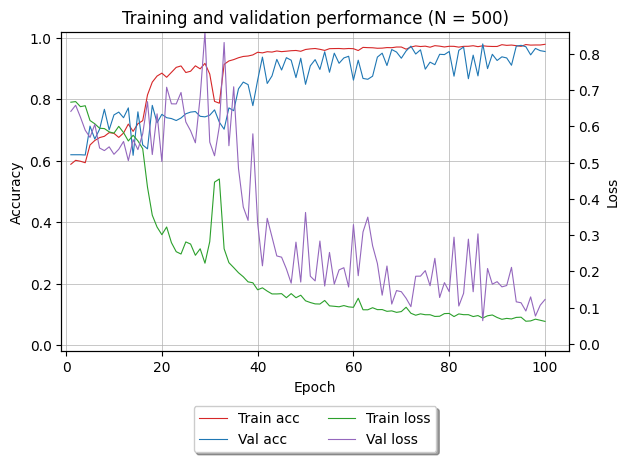

In [60]:
# Plot accuracies

# Assuming you have these lists defined:
# train_accuracies, val_accuracies, train_losses, val_losses

epoch_list = [epoch + 1 for epoch in range(num_epochs)]

# Create the figure and the first subplot (for accuracy)
fig, ax1 = plt.subplots()

lw = 0.8 # Line width

# Plot the accuracy data on the first y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.plot(epoch_list, train_accuracies, label='Train acc', color='tab:red', linewidth=lw)
ax1.plot(epoch_list, val_accuracies, label='Val acc', color='tab:blue', linewidth=lw)
ax1.set_ylim(-0.02, 1.02)
ax1.grid(True, linestyle='solid', linewidth=0.5)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

# Plot the loss data on the second y-axis
ax2.set_ylabel('Loss')
ax2.plot(epoch_list, train_losses, label='Train loss', color='tab:green', linewidth=lw)
ax2.plot(epoch_list, val_losses, label='Val loss', color='tab:purple', linewidth=lw)
ax2.set_ylim(-0.02, max(max(train_losses), max(val_losses)))
ax2.set_xlim(left=-1) # Lower bound

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Place legend outside the plot below
plt.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=2)

plt.title('Training and validation performance')
fig.tight_layout()  # otherwise the right y-label might be slightly clipped
plt.show()